In [3]:
DF_PATH = r"../data/raw/explored_df.pkl"
EXPORT_PATH = r"../data/processed"
RAW_PATH = r"../data/raw"

In [4]:
# Load packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pickle
import joblib

## imbalance
from imblearn.over_sampling import SMOTE

## skelarn -- preprocessing
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder, LabelEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn_features.transformers import DataFrameSelector

## skelarn -- models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier

## sklearn -- metrics
from sklearn.metrics import f1_score, confusion_matrix, classification_report, accuracy_score
from sklearn.metrics import precision_score, recall_score, RocCurveDisplay, roc_auc_score

## sklearn -- tuning
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, KFold, cross_val_score

In [5]:
# load data with pickle
def load_data(path):
    with open(path, 'rb') as f:
        return pickle.load(f)

X_train = load_data(os.path.join(RAW_PATH, 'X_train_total.pkl'))
y_train = load_data(os.path.join(RAW_PATH, 'y_train_total.pkl'))
X_test  = load_data(os.path.join(EXPORT_PATH, 'X_test.pkl'))
y_test  = load_data(os.path.join(EXPORT_PATH, 'y_test.pkl'))
print('Train set unprocessed:', X_train.shape, y_train.shape)
print('Test set unprocessed :', X_test.shape, y_test.shape)

Train set unprocessed: (5271, 18) (5271,)
Test set unprocessed : (1318, 18) (1318,)


### Create pipeline to transform data

In [6]:
num_cols = ['age', 'number_of_dependents', 'number_of_referrals', 'tenure_in_months', 'avg_monthly_long_distance_charges',
            'avg_monthly_gb_download', 'total_revenue', 'enrolled_services']

cat_cols = ['married', 'phone_service', 'multiple_lines', 'internet_service', 'unlimited_data', 'paperless_billing', 'offer', 'payment_method']

ord_cols_1 = ['internet_type']
ord_cols_2 = ['contract']

In [7]:
## Pipeline

## Numerical: num_cols --> Imputing using median, and standardscaler
## Categorical: cat_cols ---> Imputing using mode, and OHE
## Ordinal: ord_cols_1, ord_cols_2 ---> Imputing using mode, and ordinalEncoder

## For Numerical
num_pipeline = Pipeline(steps=[
                        ('selector', DataFrameSelector(num_cols)),
                        ('imputer', SimpleImputer(strategy='median')),
                        ('scaler', MinMaxScaler())
                    ])


## For Categorical
cat_pipeline = Pipeline(steps=[
                        ('selector', DataFrameSelector(cat_cols)),
                        ('imputer', SimpleImputer(strategy='most_frequent')),
                        ('ohe', OneHotEncoder(drop='first', sparse_output=False))
                    ])


## For ord_cols_1
ordinal_pipeline_1 = Pipeline(steps=[
                        ('selector', DataFrameSelector(ord_cols_1)),
                        ('imputer', SimpleImputer(strategy='most_frequent')),
                        ('encoder',OrdinalEncoder(categories=[['No', 'Cable', 'DSL', 'Fiber Optic']]))
                    ])


## For ord_cols_1
ordinal_pipeline_2 = Pipeline(steps=[
                        ('selector', DataFrameSelector(ord_cols_2)),
                        ('imputer', SimpleImputer(strategy='most_frequent')),
                        ('encoder',OrdinalEncoder(categories=[['Month-to-Month', 'One Year', 'Two Year']]))
                    ])


## combine all
all_pipeline = FeatureUnion(transformer_list=[
                                    ('numerical', num_pipeline),
                                    ('categorical', cat_pipeline),
                                    ('ord_1', ordinal_pipeline_1),
                                    ('ord_2', ordinal_pipeline_2)
                                ])

## apply
X_train_final = all_pipeline.fit_transform(X_train)
X_test_final = all_pipeline.transform(X_test)

e:\Epsilon_DS\finalProject\STREAMLIT\lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
e:\Epsilon_DS\finalProject\STREAMLIT\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
e:\Epsilon_DS\finalProject\STREAMLIT\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
e:\Epsilon_DS\finalProject\STREAMLIT\lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check 

In [8]:
joblib.dump(all_pipeline, '../models/pipeline.pkl')

['../models/pipeline.pkl']

In [9]:
print(X_train_final.shape)
print(X_test_final.shape)

(5271, 22)
(1318, 22)


### Solving class imbalance using SMOTE for over sampling

In [10]:
# transform target
le = LabelEncoder()
y_train_final = le.fit_transform(y_train)
y_test_final = le.transform(y_test)

e:\Epsilon_DS\finalProject\STREAMLIT\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
e:\Epsilon_DS\finalProject\STREAMLIT\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
e:\Epsilon_DS\finalProject\STREAMLIT\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
e:\Epsilon_DS\finalProject\STREAMLIT\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if

In [11]:
print(y_train_final[:5])
print(y_test_final[:5])

[1 0 1 1 1]
[1 0 1 1 1]


In [12]:
over = SMOTE(sampling_strategy=0.8, random_state=42)
X_train_resampled, y_train_resampled = over.fit_resample(X_train_final, y_train_final)

In [13]:
print(X_train_resampled.shape)
print(y_train_resampled.shape)

(6796, 22)
(6796,)


### Training RandomForest on total training data

RandomForestClassifier(max_features=15, max_leaf_nodes=24, n_estimators=75)
Results on Test data
Test accuracy =  0.8649
Test precision =  0.9209
Test recall =  0.8877
Classification report:
              precision    recall  f1-score   support

           0       0.74      0.81      0.77       374
           1       0.92      0.89      0.90       944

    accuracy                           0.86      1318
   macro avg       0.83      0.85      0.84      1318
weighted avg       0.87      0.86      0.87      1318

Confusion matrix (Rows actual, Columns predicted):
     0    1
0  302   72
1  106  838

ROC curve


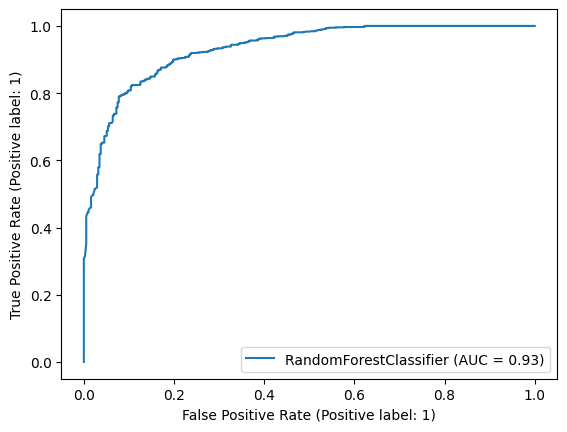

In [14]:
# Best Hyperparameters from last notebook
max_features = 15
max_leaf_nodes = 24 
n_estimators = 75

# Train and test model
good_model_rf = RandomForestClassifier(max_leaf_nodes = max_leaf_nodes,
                                    max_features = max_features, 
                                    n_estimators=n_estimators) 

print(good_model_rf) # display model parameters
good_model_rf.fit(X_train_resampled, y_train_resampled) # train model
pred_rf = good_model_rf.predict(X_test_final) 

print("Results on Test data")
acc_rf = accuracy_score(y_test_final, pred_rf) 
prec_rf = precision_score(y_test_final, pred_rf) 
reca_rf = recall_score(y_test_final, pred_rf) 

print(f'Test accuracy = {acc_rf: .4f}') 
print(f'Test precision = {prec_rf: .4f}')
print(f'Test recall = {reca_rf: .4f}') 
print("Classification report:")
print(classification_report(y_test_final, pred_rf))
print("Confusion matrix (Rows actual, Columns predicted):")
print(pd.DataFrame(confusion_matrix(y_test_final, pred_rf)))

print('\nROC curve')
RocCurveDisplay.from_estimator(good_model_rf, X_test_final, y_test_final)
plt.show()

### Training XGBoost on total training data

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.5, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=200, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=42, ...)
Results on Test data
Test accuracy =  0.8657
Test precision =  0.9050
Test recall =  0.9078
Classification report:
              precision    recall  f1-score   support

           0       0.77      0.76      0.76       374
           1       0.90 

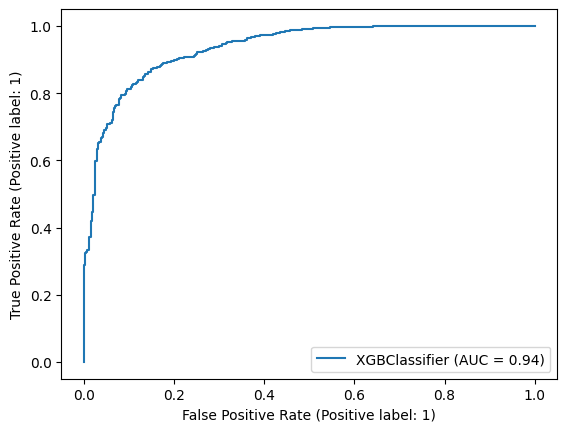

In [15]:
# Best Hyperparameters from last notebook
booster = 'gbtree'
gamma = 0.5
learning_rate = 0.1
n_estimators = 200
reg_alpha = 0.5
reg_lambda = 1

# Train and test model
good_model_xgb = XGBClassifier(booster = 'gbtree',
                              gamma = 0.5,
                              learning_rate = 0.1,
                              n_estimators = 200,
                              reg_alpha = 0.5,
                              reg_lambda = 1, random_state=42) 

print(good_model_xgb) # display model parameters
good_model_xgb.fit(X_train_resampled, y_train_resampled) # train model
pred_xgb = good_model_xgb.predict(X_test_final) 

print("Results on Test data")
acc_xgb = accuracy_score(y_test_final, pred_xgb) 
prec_xgb = precision_score(y_test_final, pred_xgb) 
reca_xgb = recall_score(y_test_final, pred_xgb) 

print(f'Test accuracy = {acc_xgb: .4f}') 
print(f'Test precision = {prec_xgb: .4f}')
print(f'Test recall = {reca_xgb: .4f}') 
print("Classification report:")
print(classification_report(y_test_final, pred_xgb))
print("Confusion matrix (Rows actual, Columns predicted):")
print(pd.DataFrame(confusion_matrix(y_test_final, pred_xgb)))

print('\nROC curve')
RocCurveDisplay.from_estimator(good_model_xgb, X_test_final, y_test_final)
plt.show()

### XGBoost wins 
- I will save both models anyways

In [16]:
models_opt = []

models_opt.append(('XGBoost', XGBClassifier(booster = 'gbtree', gamma = 0.5, learning_rate = 0.1, n_estimators = 200,
                              reg_alpha = 0.5, reg_lambda = 1, random_state=42)))
models_opt.append(('Random Forest', RandomForestClassifier(max_leaf_nodes=15, max_features=24, n_estimators=75, criterion='gini', random_state=42)))

In [17]:
acc_results_opt =[]
auc_results_opt =[]
pre_results_opt =[]
f1_results_opt =[]
names_opt = []

result_col_opt = ["Algorithm", "ROC AUC", "Accuracy", 'Precision', 'F1 Scores']
model_results_opt = pd.DataFrame(columns = result_col_opt)

i=0
# K- fold cross validation

for name, model in models_opt:
    names_opt.append(name)
    
    cv_acc_results_opt = cross_val_score(model, X_train_resampled, y_train_resampled, scoring="accuracy")
    cv_auc_results_opt = cross_val_score(model, X_train_resampled, y_train_resampled, scoring="roc_auc")
    cv_pre_results_opt = cross_val_score(model, X_train_resampled, y_train_resampled, scoring="precision")
    cv_f1_results_opt = cross_val_score(model, X_train_resampled, y_train_resampled, scoring="f1")

    acc_results_opt.append(cv_acc_results_opt)
    auc_results_opt.append(cv_auc_results_opt)
    pre_results_opt.append(cv_pre_results_opt)
    f1_results_opt.append(cv_f1_results_opt)
    
    model_results_opt.loc[i] = [name, 
                           round(cv_auc_results_opt.mean()*100,2),
                           round(cv_acc_results_opt.mean()*100,2),
                           round(cv_pre_results_opt.mean()*100,2),
                           round(cv_f1_results_opt.mean()*100,2)]
    i+=1

model_results_opt.sort_values(by = ['ROC AUC'], ascending=False)

,Algorithm,ROC AUC,Accuracy,Precision,F1 Scores
0,XGBoost,96.02,88.49,89.85,89.85
1,Random Forest,93.08,85.02,85.26,86.78


In [18]:
# precision_score  recall_score

acc_results_opt_val =[]
auc_results_opt_val =[]
pre_results_opt_val =[]
f1_results_opt_val =[]
rec_results_opt_val =[]
names_opt_val = []
good_models_names = [('RandomForest', pred_rf), ('XGBoost', pred_xgb)]

result_col_opt = ["Algorithm", "ROC AUC", "Accuracy", 'Precision', 'Recall', 'F1 Scores']
model_results_opt_val = pd.DataFrame(columns = result_col_opt)

i=0
# K- fold cross validation

for name, y_pred in good_models_names:
    names_opt_val.append(name)
    
    cv_acc_results_opt = accuracy_score(y_test_final, y_pred)
    cv_auc_results_opt = roc_auc_score(y_test_final, y_pred)
    cv_pre_results_opt = precision_score(y_test_final, y_pred)
    cv_f1_results_opt = f1_score(y_test_final, y_pred)
    cv_rec_results_opt = recall_score(y_test_final, y_pred)

    acc_results_opt_val.append(cv_acc_results_opt)
    auc_results_opt_val.append(cv_auc_results_opt)
    pre_results_opt_val.append(cv_pre_results_opt)
    f1_results_opt_val.append(cv_f1_results_opt)
    rec_results_opt_val.append(cv_rec_results_opt)

    model_results_opt_val.loc[i] = [name, 
                           round(cv_auc_results_opt.mean()*100,2),
                           round(cv_acc_results_opt.mean()*100,2),
                           round(cv_pre_results_opt.mean()*100,2),
                           round(cv_rec_results_opt.mean()*100,2),
                           round(cv_f1_results_opt.mean()*100,2)]
    i+=1

model_results_opt_val.sort_values(by = ['ROC AUC'], ascending=False)

,Algorithm,ROC AUC,Accuracy,Precision,Recall,F1 Scores
0,RandomForest,84.76,86.49,92.09,88.77,90.40
1,XGBoost,83.36,86.57,90.50,90.78,90.64


###

### Saving models

In [19]:
# save random forest
joblib.dump(good_model_rf, '../models/forest_tuned.pkl')

# save xgboost
joblib.dump(good_model_xgb, '../models/XGBoost_tuned.pkl')


['../models/XGBoost_tuned.pkl']